In [1]:
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import os
import pandas as pd
import base64
from PIL import Image
from io import BytesIO
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torchvision import models
import numpy as np
from transformers import ViTFeatureExtractor, ViTForImageClassification

import numpy as np
import os
import random
import torch 

import torch.nn as nn
import torch.optim as optim

# this function guarantees reproductivity
# other packages also support seed options, you can add to this function
def seed_everything(TORCH_SEED):
    random.seed(TORCH_SEED)
    os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)
    np.random.seed(TORCH_SEED)
    torch.manual_seed(TORCH_SEED)
    torch.cuda.manual_seed_all(TORCH_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

2024-04-09 19:02:42.496760: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 19:02:42.496880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 19:02:42.634041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Предобработка данных

In [2]:
ekb_images = pd.read_csv('/kaggle/input/nto-full/EKB_images.csv')
ekb_places = pd.read_csv('/kaggle/input/nto-full/EKB_places.csv')

nn_images = pd.read_csv('/kaggle/input/nto-full/NN_images.csv')
nn_places = pd.read_csv('/kaggle/input/nto-full/NN_places.csv')

vladimir_images = pd.read_csv('/kaggle/input/nto-full/Vladimir_images.csv')
vladimir_places = pd.read_csv('/kaggle/input/nto-full/Vladimir_places.csv')

yaroslavl_images = pd.read_csv('/kaggle/input/nto-full/yaroslavl_images.csv')
yaroslavl_places = pd.read_csv('/kaggle/input/nto-full/Yaroslavl_places.csv')

In [3]:
def preprocess_data(ekb_images, ekb_places):
    ekb_places = ekb_places.loc[:, ['XID','Name',  'Kind']]
    ekb_places.rename(columns={'Name': 'name'}, inplace=True)
    ekb_df = pd.merge(ekb_images, ekb_places, on = 'name')
    label_encoder = LabelEncoder()
    
    labels_list = ekb_df['Kind'].str.split(',')

    encoded_labels_list = []

    for labels in labels_list:
        encoded_labels = label_encoder.fit_transform(labels)
        encoded_labels_list.append(encoded_labels)

    ekb_df['Kind'] = encoded_labels_list
    all_labels = []

    for labels in labels_list:
        all_labels.extend(labels)

    unique_labels = set(all_labels)

    label2idx = {label: i for i, label in enumerate(unique_labels)}

    encoded_labels_list = [[label2idx[label] for label in labels] for labels in labels_list]

    ekb_df['Kind'] = encoded_labels_list
    idx2label = {v: k for k, v in label2idx.items()}
    print(len(idx2label))
    return ekb_df, label2idx, idx2label

In [4]:
ekb_df, label2idx_ekb, idx2label_ekb = preprocess_data(ekb_images, ekb_places)
nn_df, label2idx_nn, idx2label_nn = preprocess_data(nn_images, nn_places)
vladimir_df, label2idx_vladimir, idx2label_vladimir = preprocess_data(vladimir_images, vladimir_places)
yaroslavl_df, label2idx_yaroslavl, idx2label_yaroslavl = preprocess_data(yaroslavl_images, yaroslavl_places)

54
49
59
56


In [5]:
train_df_ekb, val_df_ekb = train_test_split(ekb_df, test_size=0.2, random_state=42)
train_df_nn, val_df_nn = train_test_split(nn_df, test_size=0.2, random_state=42)
train_df_vladimir, val_df_vladimir = train_test_split(vladimir_df, test_size=0.2, random_state=42)
train_df_yaroslavl, val_df_yaroslavl = train_test_split(yaroslavl_df, test_size=0.2, random_state=42)

In [6]:
# def get_model():
#     pretrained_model_ekb = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

#     for param in pretrained_model_ekb.parameters():
#         param.requires_grad = False

#     num_classes = 54
#     pretrained_model_ekb.classifier = nn.Sequential(
#         nn.Dropout(p=0.2, inplace=False),
#         nn.Linear(in_features=pretrained_model_ekb.last_channel, out_features=num_classes, bias=True)
#     )

#     criterion = nn.BCEWithLogitsLoss()
#     optimizer = optim.Adam(pretrained_model_ekb.classifier.parameters(), lr=0.001)

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     pretrained_model_ekb.to(device)
#     return pretrained_model_ekb

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None,num = 1, ist = 0, is_img = 0):
        self.dataframe = dataframe
        self.transform = transform
        self.ist = ist
        self.num = num
        self.is_img = is_img
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        if self.is_img == 0:
            img_path = row['image']
        else:
            img_path = row['img']
        if self.ist == 0:
          label = row['name']
        image = Image.open(BytesIO(base64.b64decode(img_path))).convert('RGB')
        tags = row.Kind
        if self.num == 1:
            target = np.zeros(54)
        elif self.num == 2:
            target = np.zeros(49)
        elif self.num == 3:
            target = np.zeros(59)
        elif self.num == 4:
            target = np.zeros(56)
        target[tags] = 1
        if self.transform:
            image = self.transform(image)
        return image, target

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.RandomChoice([
            transforms.ColorJitter(hue=0.1),
            transforms.ColorJitter(brightness=0.2),
            transforms.ColorJitter(saturation=0.2),
            transforms.ColorJitter(contrast=0.2),
        ]),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
batch_size = 128

def get_loader(df, transform, num, is_img = 0):  
    train_dataset = CustomDataset(dataframe=df,num = num, transform=transform, is_img = is_img)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

train_loader_ekb = get_loader(train_df_ekb,num = 1, transform=train_transform)    
val_loader_ekb = get_loader(val_df_ekb,num = 1, transform=test_transform)

train_loader_nn = get_loader(train_df_nn,num = 2, transform=train_transform)    
val_loader_nn = get_loader(val_df_nn,num = 2, transform=test_transform)

train_loader_vladimir = get_loader(train_df_vladimir, num = 3,transform=train_transform)    
val_loader_vladimir = get_loader(val_df_vladimir, num = 3,transform=test_transform)

train_loader_yaroslavl = get_loader(train_df_yaroslavl,num = 4, transform=train_transform, is_img = 1)    
val_loader_yaroslavl = get_loader(val_df_yaroslavl,num = 4, transform=test_transform, is_img = 1)

## Модели

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

pretrained_model_ekb = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

for param in pretrained_model_ekb.parameters():
    param.requires_grad = False

num_classes = 54
pretrained_model_ekb.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=pretrained_model_ekb.last_channel, out_features=num_classes, bias=True)
)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(pretrained_model_ekb.classifier.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model_ekb.to(device)


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 65.7MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
def train_model(model, train_loader,val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        val_loss, avg_precision = evaluate_model(model, val_loader, criterion, device)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Average precision: {avg_precision:.4f}')

    return model

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    corrects = torch.sum(preds == labels.data)
    return corrects.double() / len(labels)

from sklearn.metrics import average_precision_score

def evaluate_model(model, val_loader, criterion, device='cuda'):
    model.eval()
    val_loss = 0.0
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            y_true.extend(labels.cpu().numpy())  
            y_scores.extend(outputs.sigmoid().cpu().numpy())  

    val_loss /= len(val_loader.dataset)

    # Calculate average precision
    avg_precision = average_precision_score(y_true, y_scores, average='micro')

    return val_loss, avg_precision


In [14]:
pretrained_model_nn = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

for param in pretrained_model_nn.parameters():
    param.requires_grad = False

num_classes = 49
pretrained_model_nn.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=pretrained_model_nn.last_channel, out_features=num_classes, bias=True)
)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(pretrained_model_nn.classifier.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model_nn.to(device)
# model_nn = train_model(model_nn, train_loader_nn, val_loader_nn, criterion, optimizer, num_epochs=40)
model_nn = train_model(pretrained_model_nn, train_loader_nn, val_loader_nn, criterion, optimizer, num_epochs=40)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/40, Train Loss: 0.2709, Validation Loss: 0.2254, Average precision: 0.6561
Epoch 2/40, Train Loss: 0.2023, Validation Loss: 0.1877, Average precision: 0.7197
Epoch 3/40, Train Loss: 0.1801, Validation Loss: 0.1733, Average precision: 0.7464
Epoch 4/40, Train Loss: 0.1705, Validation Loss: 0.1652, Average precision: 0.7597
Epoch 5/40, Train Loss: 0.1627, Validation Loss: 0.1564, Average precision: 0.7816
Epoch 6/40, Train Loss: 0.1579, Validation Loss: 0.1533, Average precision: 0.7867
Epoch 7/40, Train Loss: 0.1551, Validation Loss: 0.1473, Average precision: 0.8015
Epoch 8/40, Train Loss: 0.1492, Validation Loss: 0.1424, Average precision: 0.8076
Epoch 9/40, Train Loss: 0.1482, Validation Loss: 0.1408, Average precision: 0.8102
Epoch 10/40, Train Loss: 0.1454, Validation Loss: 0.1357, Average precision: 0.8227
Epoch 11/40, Train Loss: 0.1442, Validation Loss: 0.1352, Average precision: 0.8224
Epoch 12/40, Train Loss: 0.1412, Validation Loss: 0.1342, Average precision: 0.8270
E

In [ ]:
pretrained_model_ekb = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

for param in pretrained_model_ekb.parameters():
    param.requires_grad = False

num_classes = 54
pretrained_model_ekb.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=pretrained_model_ekb.last_channel, out_features=num_classes, bias=True)
)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(pretrained_model_ekb.classifier.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model_ekb.to(device)
# model_nn = train_model(model_nn, train_loader_nn, val_loader_nn, criterion, optimizer, num_epochs=40)
model_nn = train_model(pretrained_model_ekb, train_loader_ekb, val_loader_ekb, criterion, optimizer, num_epochs=40)

In [19]:
pretrained_model_vladimir = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

for param in pretrained_model_vladimir.parameters():
    param.requires_grad = False

num_classes = 59
pretrained_model_vladimir.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=pretrained_model_vladimir.last_channel, out_features=num_classes, bias=True)
)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(pretrained_model_vladimir.classifier.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model_vladimir.to(device)
model_vladimir = train_model(pretrained_model_vladimir, train_loader_vladimir, val_loader_vladimir, criterion, optimizer, num_epochs=40)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/40, Train Loss: 0.2344, Validation Loss: 0.1761, Average precision: 0.5996
Epoch 2/40, Train Loss: 0.1720, Validation Loss: 0.1569, Average precision: 0.6404
Epoch 3/40, Train Loss: 0.1581, Validation Loss: 0.1459, Average precision: 0.6691
Epoch 4/40, Train Loss: 0.1510, Validation Loss: 0.1396, Average precision: 0.6839
Epoch 5/40, Train Loss: 0.1456, Validation Loss: 0.1353, Average precision: 0.6985
Epoch 6/40, Train Loss: 0.1421, Validation Loss: 0.1299, Average precision: 0.7175
Epoch 7/40, Train Loss: 0.1383, Validation Loss: 0.1265, Average precision: 0.7281
Epoch 8/40, Train Loss: 0.1349, Validation Loss: 0.1251, Average precision: 0.7292
Epoch 9/40, Train Loss: 0.1331, Validation Loss: 0.1217, Average precision: 0.7434
Epoch 10/40, Train Loss: 0.1297, Validation Loss: 0.1192, Average precision: 0.7483
Epoch 11/40, Train Loss: 0.1288, Validation Loss: 0.1182, Average precision: 0.7519
Epoch 12/40, Train Loss: 0.1276, Validation Loss: 0.1167, Average precision: 0.7556
E

In [20]:
import joblib
joblib.dump(pretrained_model_nn, 'model_vladimir.pkl')

['model_vladimir.pkl']

In [120]:
pretrained_model_yaroslavl = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

for param in pretrained_model_yaroslavl.parameters():
    param.requires_grad = False

num_classes = 56
pretrained_model_yaroslavl.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=pretrained_model_yaroslavl.last_channel, out_features=num_classes, bias=True)
)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(pretrained_model_yaroslavl.classifier.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model_yaroslavl.to(device)
# model_nn = train_model(model_nn, train_loader_nn, val_loader_nn, criterion, optimizer, num_epochs=40)
model_yaroslavl = train_model(pretrained_model_yaroslavl, train_loader_yaroslavl, val_loader_yaroslavl, criterion, optimizer, num_epochs=40)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/40, Train Loss: 0.2301, Validation Loss: 0.1865, Average precision: 0.6227
Epoch 2/40, Train Loss: 0.1694, Validation Loss: 0.1620, Average precision: 0.6789
Epoch 3/40, Train Loss: 0.1555, Validation Loss: 0.1500, Average precision: 0.6985
Epoch 4/40, Train Loss: 0.1485, Validation Loss: 0.1436, Average precision: 0.7210
Epoch 5/40, Train Loss: 0.1436, Validation Loss: 0.1384, Average precision: 0.7325
Epoch 6/40, Train Loss: 0.1396, Validation Loss: 0.1351, Average precision: 0.7441
Epoch 7/40, Train Loss: 0.1354, Validation Loss: 0.1316, Average precision: 0.7524
Epoch 8/40, Train Loss: 0.1346, Validation Loss: 0.1286, Average precision: 0.7598
Epoch 9/40, Train Loss: 0.1306, Validation Loss: 0.1247, Average precision: 0.7693
Epoch 10/40, Train Loss: 0.1299, Validation Loss: 0.1238, Average precision: 0.7718
Epoch 11/40, Train Loss: 0.1286, Validation Loss: 0.1220, Average precision: 0.7782
Epoch 12/40, Train Loss: 0.1254, Validation Loss: 0.1205, Average precision: 0.7835
E

KeyboardInterrupt: 

In [121]:
output_onnx_path = 'model_yaroslavl.onnx'
torch.onnx.export(pretrained_model_yaroslavl.to('cpu'), picture.unsqueeze(0), output_onnx_path)

In [122]:
import joblib
joblib.dump(pretrained_model_yaroslavl, 'model_yaroslavl.pkl')

['model_yaroslavl.pkl']

## Пример подгрузки модели

In [66]:
import joblib
model = joblib.load('/kaggle/working/model_vladimir.pkl')

In [77]:
# Получим ответ
picture = ekb_df['image'][3]
picture = Image.open(BytesIO(base64.b64decode(picture))).convert('RGB')
image = test_transform(picture)
ans = model(image.unsqueeze(0))

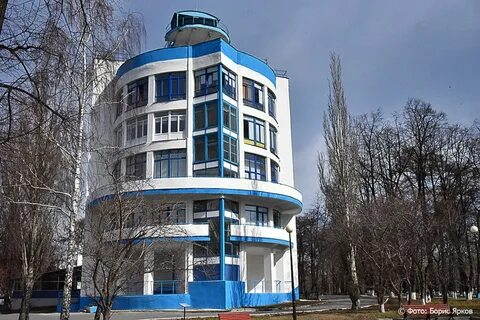

In [79]:
picture

In [78]:
top_k = 5

top_k_values, top_k_indices = torch.topk(torch.sigmoid(ans), top_k, dim=1)

top_k_labels = [idx2label_vladimir[idx.item()] for idx in top_k_indices[0]]

for i in range(top_k):
    print(f"Предсказание {i + 1}: {top_k_labels[i]} с вероятностью {top_k_values[0][i].item():.4f}")

Предсказание 1: historic_architecture с вероятностью 1.0000
Предсказание 2: defensive_walls с вероятностью 0.5095
Предсказание 3: theatres_and_entertainments с вероятностью 0.1425
Предсказание 4: view_points с вероятностью 0.1029
Предсказание 5: other_technology_museums с вероятностью 0.0957


## ONNX

In [22]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.5 MB/s eta 0:00:00


In [16]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [26]:
picture = vladimir_df['image'][3] # Подгружаем картинку
picture = Image.open(BytesIO(base64.b64decode(picture))).convert('RGB')
picture = test_transform(picture)

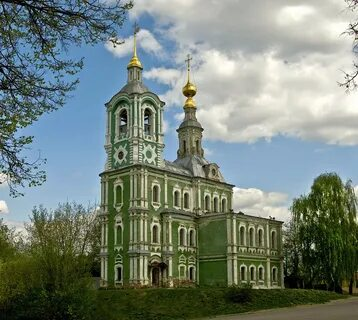

In [25]:
picture

In [28]:
import onnxruntime

onnx_model_path = '/kaggle/working/model_vladimir.onnx'
ort_session = onnxruntime.InferenceSession(onnx_model_path)

sample_input = np.array(picture.unsqueeze(0)).astype(np.float32)  

ort_inputs = {ort_session.get_inputs()[0].name: sample_input}
ort_outputs = ort_session.run(None, ort_inputs)

In [29]:
import torch
import onnxruntime

def answer_from_onnx(image):
    onnx_model_path = '/kaggle/working/model_vladimir.onnx'
    ort_session = onnxruntime.InferenceSession(onnx_model_path)

    sample_input = np.array(picture.unsqueeze(0)).astype(np.float32)  

    ort_inputs = {ort_session.get_inputs()[0].name: sample_input}
    ort_outputs = ort_session.run(None, ort_inputs)
    top_k = 5

    top_k_values, top_k_indices = torch.topk(torch.sigmoid(torch.Tensor(ort_outputs[0])), top_k, dim=1)

    top_k_labels = [idx2label[idx.item()] for idx in top_k_indices[0]]
    return top_k_labels #5 наиболее подходящих категорий

In [37]:
top_k = 5

top_k_values, top_k_indices = torch.topk(torch.sigmoid(pretrained_model_vladimir(picture.to('cuda').unsqueeze(0))), top_k, dim=1)

top_k_labels = [idx2label_vladimir[idx.item()] for idx in top_k_indices[0]]

for i in range(top_k):
    print(f"Предсказание {i + 1}: {top_k_labels[i]} с вероятностью {top_k_values[0][i].item():.4f}")

Предсказание 1: interesting_places с вероятностью 1.0000
Предсказание 2: religion с вероятностью 0.8662
Предсказание 3: churches с вероятностью 0.6821
Предсказание 4: eastern_orthodox_churches с вероятностью 0.5410
Предсказание 5: other_temples с вероятностью 0.1629


In [198]:
top_k = 5

top_k_values, top_k_indices = torch.topk(torch.sigmoid(model(inputs.to('cuda'))), top_k, dim=1)

top_k_labels = [idx2label[idx.item()] for idx in top_k_indices[0]]

for i in range(top_k):
    print(f"Предсказание {i + 1}: {top_k_labels[i]} с вероятностью {top_k_values[0][i].item():.4f}")

Предсказание 1: interesting_places с вероятностью 1.0000
Предсказание 2: architecture с вероятностью 0.8710
Предсказание 3: historic_architecture с вероятностью 0.8061
Предсказание 4: other_buildings_and_structures с вероятностью 0.7018
Предсказание 5: stadiums с вероятностью 0.4679


In [ ]:
import onnxruntime

onnx_model_path = '/kaggle/working/model_vladimir.onnx'
ort_session = onnxruntime.InferenceSession(onnx_model_path)

sample_input = np.array(picture.unsqueeze(0)).astype(np.float32)  

ort_inputs = {ort_session.get_inputs()[0].name: sample_input}
ort_outputs = ort_session.run(None, ort_inputs)